In [16]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm.notebook import tqdm
import scprep
import phate

In [2]:

nas_path = "./dataset_1401/"
lineage_label = np.array(pd.read_csv('./dataset_1401/1404_lineage_report and metadata 20220316.csv')[['lineage_x','diff']])
label_ = []
new_lineage_label = []
for idx, rna in enumerate(SeqIO.parse('./dataset_1401/1404.sequences.aln.fasta',"fasta")):
    if "B.1.617.2" == lineage_label[idx][0]:
    # break
    # print(lineage_label[idx][0].split(' ')[0])
        label_.append(lineage_label[idx][1].split(' ')[0])

        new_lineage_label.append(str(rna.seq))

In [3]:
print('sample:', len(new_lineage_label))

sample: 1135


In [4]:
class_,_ ,_,_= np.unique(label_,return_counts=True,return_index=True,return_inverse=True)
print(class_)

['N' 'Y']


In [5]:
# # only tcga rna unit
def clean(x):
	x = x.upper() 
	
	if x == 'T' or x == 'A' or x == 'G' or x == 'C' or x == '-' or x == 'N':
		return x

	if x == 'U' or x == 'Y':
		return 'T'
	
	if x == 'K' or x == 'S':
		return 'G'

	if x == 'M' or x == 'R' or x == 'W' or x == 'H' or x=='V' or x=='D':
		return 'A'

	if x== 'B':
		return 'C'
from itertools import product
dict_search = {}
for idx, i in enumerate('-NACGT'):

    dict_search[i] = idx
print(dict_search)
from tqdm.notebook import tqdm
num_new_sequences =[]
for k in tqdm(new_lineage_label):
	temp_store=[]
	for j in k:
		temp_store.append(dict_search[clean(j)])
	num_new_sequences.append(temp_store)
total_sequence_array = np.array(num_new_sequences)
print(total_sequence_array.shape)


{'-': 0, 'N': 1, 'A': 2, 'C': 3, 'G': 4, 'T': 5}


  0%|          | 0/1135 [00:00<?, ?it/s]

(1135, 29903)


In [6]:
class_dict_ = {}
for idx, i in enumerate(class_):
    class_dict_[i] = idx
print(class_dict_)
multi_label = []
for i in label_:
    multi_label.append(class_dict_[i])

{'N': 0, 'Y': 1}


In [7]:
print(label_[0:20])
print(multi_label[0:20])

['Y', 'N', 'N', 'Y', 'N', 'N', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'N', 'Y']
[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]


In [8]:
class LogScaler:
    def __init__(self):
        self._min0 = None
        self._max = None
        pass

    def fit(self, X, y=None):
        self._min0 = X.min(axis=0)
        self._max = np.log(X + np.abs(self._min0) + 1).max()

    def fit_transform(self, X, y=None):
        self._min0 = X.min(axis=0)
        X_norm = np.log(X + np.abs(self._min0) + 1)
        self._max = X_norm.max()
        return X_norm / self._max

    def transform(self, X, y=None):
        X_norm = np.log(X + np.abs(self._min0) + 1).clip(0, None)
        return (X_norm / self._max).clip(0, 1)

In [9]:
ln = LogScaler()
X_train_norm = ln.fit_transform(total_sequence_array)

In [10]:
X_train_norm.T.shape, X_train_norm.shape

((29903, 1135), (1135, 29903))

In [11]:
phate_op = phate.PHATE(n_jobs=-2)
data_phate = phate_op.fit_transform(X_train_norm.T)

Calculating PHATE...
  Running PHATE on 29903 observations and 1135 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.30 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.20 seconds.
    Calculating affinities...


/home/john/anaconda3/envs/phate/lib/python3.7/site-packages/graphtools/graphs.py:293: RuntimeWarning: Detected zero distance between 182846 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  RuntimeWarning,
/home/john/anaconda3/envs/phate/lib/python3.7/site-packages/graphtools/graphs.py:451: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 3.82 seconds.
  Calculated graph and diffusion operator in 23.41 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 8.13 seconds.
    Calculating KMeans...
    Calculated KMeans in 25.37 seconds.
  Calculated landmark operator in 35.40 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 5.89 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.28 seconds.
  Calculating metric MDS...
    Using SMACOF because SGD returned NaN
  Calculated metric MDS in 378.41 seconds.
Calculated PHATE in 444.49 seconds.


In [12]:
import sklearn.decomposition # PCA
import sklearn.manifold # t-SNE
pca_operator = sklearn.decomposition.PCA(n_components=100)
tsne_operator = sklearn.manifold.TSNE(n_components=2)
Y_tsne = tsne_operator.fit_transform(pca_operator.fit_transform(np.array(X_train_norm.T)))

/home/john/anaconda3/envs/phate/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/john/anaconda3/envs/phate/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

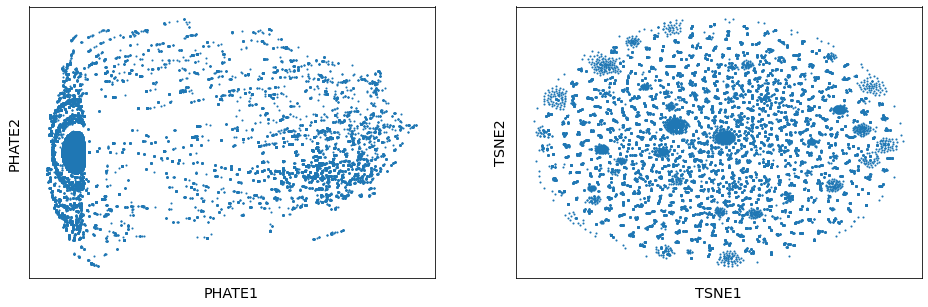

In [21]:
import matplotlib.pyplot as plt
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
# scprep.plot.scatter2d(data_phate, figsize=(12,8), cmap="Spectral",
#                       ticks=False, c=label_, label_prefix="PHATE", ax=ax1)
# scprep.plot.scatter2d(Y_tsne, figsize=(12,8), cmap="Spectral",
#                       ticks=False, c=label_, label_prefix="TSNE", ax=ax2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
scprep.plot.scatter2d(data_phate, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", ax=ax1)
scprep.plot.scatter2d(Y_tsne, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="TSNE", ax=ax2)

In [14]:
# from scipy.spatial import ConvexHull
# chvertices = ConvexHull(data_phate).vertices
# chvertices

In [15]:
# hull_points = data_phate[chvertices]
# # get polygon [x, y] points